# BOT Mean Reversion
 implementado en Binance


In [3]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from config import api_key, api_secret
plt.style.use('dark_background')
matplotlib.rcParams['timezone'] = 'GMT-5'
import numpy as np
#%matplotlib inline
client = Client( )

In [13]:
#HISTORICO 
candles = client.get_klines(symbol='PORTALUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, limit = 1000)

In [14]:
len(candles)

1000

In [23]:

price_df = pd.DataFrame(candles, columns=['dateTime',
                                          'open',
                                          'high', 'low',
                                          'close', 'volume',
                                          'closeTime', 
                                          'quoteAssetVolume',
                                          'numberOfTrades', 
                                          'takerBuyBaseVol', 
                                          'takerBuyQuoteVol', 'ignore'])
price_df.dateTime = pd.to_datetime(price_df.dateTime, unit='ms')
price_df.set_index('dateTime')
price_df.closeTime = pd.to_datetime(price_df.closeTime, unit='ms')
price_df.close = pd.to_numeric(price_df.close)
price_df.open = pd.to_numeric(price_df.open)
price_df.volume = pd.to_numeric(price_df.volume) 




In [31]:
#price_df.set_index('closeTime', inplace=True)
#closeprice = price_df['close'].to_numpy()

price_df['ma50'] = price_df.open.ewm(span=50).mean()

price_df['ma21'] = price_df.open.ewm(span=21).mean()

price_df.ma50 = pd.to_numeric(price_df.ma50)

price_df.ma21 = pd.to_numeric(price_df.ma21)

# calculate the ema distance in percentage
price_df['emaDistance'] =  ((price_df.open - price_df.ma50) / price_df.open) * 100


In [33]:
#RSI

rsi_period = 14

chg = price_df['close'].diff(1)

gain = chg.mask(chg<0,0)
price_df['gain'] = gain


loss = chg.mask(chg>0,0)
price_df['loss'] = loss

avg_gain = gain.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com = rsi_period-1,min_periods=rsi_period).mean()

price_df['avg_gain'] = avg_gain
price_df['avg_loss'] = avg_loss

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100 /(1 + rs) )
price_df['rsi'] = rsi



In [49]:
price_df['signals'] = np.where((price_df['rsi'] < 70) & (price_df['rsi'].shift(1) > 70), 1, 0)

/tmp/ipykernel_23488/2074269152.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[0].set_title(f"Precio { float( price_df.close.tail(1) ) } ")


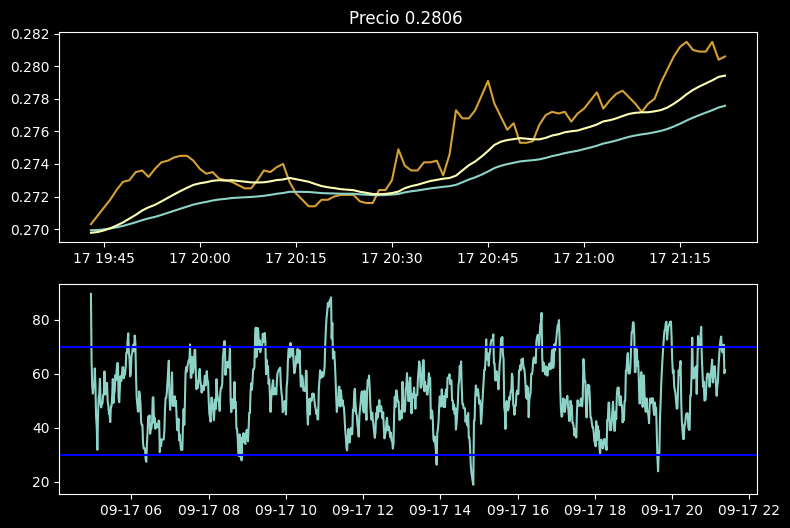

In [34]:
fig, ax = plt.subplots(2, figsize = (9,6))
tail = 100
ax[0].set_title(f"Precio { float( price_df.close.tail(1) ) } ")
ax[0].plot(price_df.closeTime.tail(tail),price_df.close.tail(tail), color = '#d5a034')
ax[0].plot(price_df.closeTime.tail(tail),price_df.ma50.tail(tail))

ax[0].plot(price_df.closeTime.tail(tail),price_df.ma21.tail(tail))
ax[0].plot(price_df.closeTime.tail(tail),price_df.signals.tail(tail))



ax[1].plot(price_df.closeTime,rsi)
# rsi bar on 70 and 30
ax[1].axhline(y= 30, color = 'b')
ax[1].axhline(y= 70, color = 'b')


In [48]:
print ('Info token :',
'\nOpen Price : ',
price_df.open.tail(1).to_string(index=False),
'\nRSI : ',
price_df.rsi.tail(1).to_string(index=False),
'\nEMA : ',
price_df.ma50.tail(1).to_string(index=False),
'\nEMA Distance :',
price_df.emaDistance.tail(1).to_string(index=False),
)




Info token : 
Open Price :  0.2802 
RSI :  61.301635 
EMA :  0.277573 
EMA Distance : 0.93741
